# **Fine-tuning for Audio Classification with 🤗 Transformers**

This notebook shows how to fine-tune multi-lingual pretrained speech models for Automatic Speech Recognition.

This notebook is built to run on the **Keyword Spotting** subset of the [SUPERB dataset](https://huggingface.co/datasets/superb) with any speech model checkpoint from the [Model Hub](https://huggingface.co/models?pipeline_tag=automatic-speech-recognition&sort=downloads) as long as that model has a version with a Sequence Classification head (e.g. [HubertForSequenceClassification](https://huggingface.co/docs/transformers/main/en/model_doc/hubert#transformers.HubertForSequenceClassification)). 

In [1]:
model_checkpoint = "facebook/hubert-base-ls960"
ipu_config_name = "Graphcore/hubert-base-ipu"

Before we start, let's install both `datasets` and `transformers` from master. Also, we need the `librosa` package to load audio files.

In [3]:
%%capture
!pip install optimum[graphcore]
!pip install datasets
!pip install transformers==4.20.0
!pip install librosa

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


Then you need to install Git-LFS to upload your model checkpoints:

In [4]:
%%capture
!apt install git-lfs

## Fine-tuning a model on an audio classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) acoustic models to a Keyword Spotting task of the [SUPERB Benchmark](https://superbbenchmark.org/)

Keyword Spotting (KS) detects preregistered keywords by classifying utterances into a predefined set of words. SUPERB uses the widely used Speech Commands dataset v1.0 for the task. The dataset consists of ten classes of keywords, a class for silence, and an unknown class to include the false positive. 

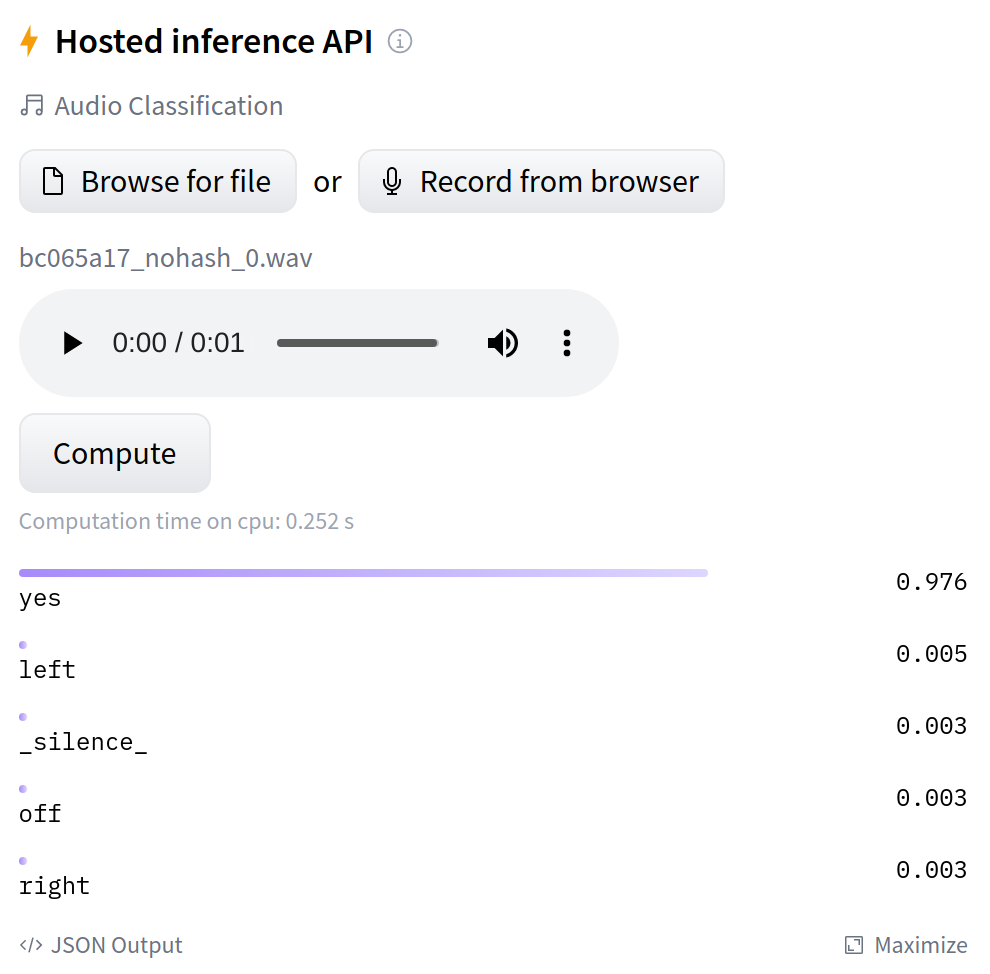

### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the Accuracy metric we need to use for evaluation. This can be easily done with the functions `load_dataset` and `load_metric`.  

In [2]:
from datasets import load_dataset, load_metric

In [3]:
dataset = load_dataset("superb", "ks")
metric = load_metric("accuracy")

Reusing dataset superb (/localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e)


  0%|          | 0/3 [00:00<?, ?it/s]

The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 51094
    })
    validation: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 6798
    })
    test: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 3081
    })
})

To access an actual element, you need to select a split first, then give an index:

In [5]:
dataset["test"][1000]

{'file': '/localdata/datasets/huggingface/datasets/downloads/extracted/e039a3c8afa5614529435cff278307a46dd7b3232a82d72c94e1bc88da543a00/go/e41a903b_nohash_4.wav',
 'audio': {'path': '/localdata/datasets/huggingface/datasets/downloads/extracted/e039a3c8afa5614529435cff278307a46dd7b3232a82d72c94e1bc88da543a00/go/e41a903b_nohash_4.wav',
  'array': array([-1.2207031e-04,  3.0517578e-05,  1.8310547e-04, ...,
         -4.8828125e-04, -5.4931641e-04, -3.3569336e-04], dtype=float32),
  'sampling_rate': 16000},
 'label': 9}

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [6]:
dataset["train"].features["label"]

ClassLabel(num_classes=12, names=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', '_silence_', '_unknown_'], id=None)

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [7]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

id2label["9"]

'go'

`HuBERT` expects the input in the format of a 1-dimensional array of 16 kHz. This means that the audio file has to be loaded and resampled.

 Thankfully, `datasets` does this automatically when calling the column `audio`. Let try it out. 

In [8]:
dataset["test"][1000]["audio"]

{'path': '/localdata/datasets/huggingface/datasets/downloads/extracted/e039a3c8afa5614529435cff278307a46dd7b3232a82d72c94e1bc88da543a00/go/e41a903b_nohash_4.wav',
 'array': array([-1.2207031e-04,  3.0517578e-05,  1.8310547e-04, ...,
        -4.8828125e-04, -5.4931641e-04, -3.3569336e-04], dtype=float32),
 'sampling_rate': 16000}

We can see that the audio file has automatically been loaded. This is thanks to the new [`"Audio"` feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=audio#datasets.Audio) introduced in `datasets == 1.13.3`, which loads and resamples audio files on-the-fly upon calling.

The sampling rate is set to 16kHz which is what `HuBERT` expects as an input.

To get a sense of what the commands sound like, the following snippet will render 
some audio examples picked randomly from the dataset. 

**Note**: *You can run the following cell a couple of times to listen to different audio samples.*

In [9]:
import random
from IPython.display import Audio, display

for _ in range(5):
    rand_idx = random.randint(0, len(dataset["train"])-1)
    example = dataset["train"][rand_idx]
    audio = example["audio"]

    print(f'Label: {id2label[str(example["label"])]}')
    print(f'Shape: {audio["array"].shape}, sampling rate: {audio["sampling_rate"]}')
    display(Audio(audio["array"], rate=audio["sampling_rate"]))
    print()

Label: on
Shape: (16000,), sampling rate: 16000



Label: _unknown_
Shape: (16000,), sampling rate: 16000



Label: no
Shape: (16000,), sampling rate: 16000



Label: _unknown_
Shape: (16000,), sampling rate: 16000



Label: _unknown_
Shape: (16000,), sampling rate: 16000


If you run the cell a couple of times, you'll see that despite slight variations in length, most of the samples are about 1 second long (`duration = audio_length / sampling_rate`). So we can safely truncate and pad the samples to `16000`.

### Preprocessing the data

Before we can feed those audio clips to our model, we need to preprocess them. This is done by a 🤗 Transformers `FeatureExtractor` which will normalize the inputs and put them in a format the model expects, as well as generate the other inputs that the model requires.

To do all of this, we instantiate our feature extractor with the `AutoFeatureExtractor.from_pretrained` method, which will ensure that we get a preprocessor that corresponds to the model architecture we want to use.

In [10]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

As we've noticed earlier, the samples are roughly 1 second long, so let's set it here:

In [11]:
max_duration = 1.0  # seconds

We can then write the function that will preprocess our samples. We just feed them to the `feature_extractor` with the argument `truncation=True`, as well as the maximum sample length. This will ensure that very long inputs like the ones in the `_silence_` class can be safely batched.

In [12]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length=int(feature_extractor.sampling_rate * max_duration), 
        truncation=True, 
    )
    return inputs

The feature extractor will return a list of numpy arays for each example:

In [13]:
preprocess_function(dataset['train'][:5])

{'input_values': [array([-9.1631009e-05, -9.1631009e-05, -9.1631009e-05, ...,
       -4.6719767e-02, -8.0353022e-01, -1.3182331e+00], dtype=float32), array([0.01049979, 0.01049979, 0.01049979, ..., 0.6454253 , 0.43378347,
       0.25741526], dtype=float32), array([ 9.0340059e-04,  9.0340059e-04,  9.0340059e-04, ...,
       -1.7281245e-01,  2.2313449e-01,  1.9931581e+00], dtype=float32), array([ 1.5586768 ,  0.3870289 ,  0.74101615, ..., -0.8897349 ,
       -0.7703889 , -0.09471782], dtype=float32), array([-0.01518929, -0.01518929, -0.01518929, ..., -0.84138   ,
        0.22227868, -0.02409434], dtype=float32)]}

To apply this function on all utterances in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [14]:
encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio", "file"], batched=True, num_proc=64)
encoded_dataset

Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-c604f702e82f3f8b.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-adc8313eb021e4ff.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-7d72f0c0f0ee2d8f.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-1412404fc4d99e9a.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-e7c67ac99b3f3f0d.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-6ee176eec5b3b0ac.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-963a73c03911c890.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-9c255abaa302c349.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-6bcfbc4d05910c25.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-730e39e2b5c2db76.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-75dc11cd54c8dffe.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-5898ada719f16263.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-f130d58b42fb3307.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-d85ab877abd17169.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-7eb310d2e275c004.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b4ed749a758e6785.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-5b0e34ddbdaf68c2.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b15497ace5163fba.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-682d1bfdf0043c40.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b4d884d806d16c5f.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-cdc7432e3895bda5.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-6e0e9df68fe0c131.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-499915fe9e30cdfe.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-01446ae69155fd91.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-9f256aa9640da4a9.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-82567d4dfeed03ae.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-4fa8bbbd6208f4f7.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-21a16a448da907e9.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-58153b62d3a0db94.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-273106277b81af3b.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-fabd60f89f4d6464.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-d94e2a2e1aeb521b.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-7ec356de99d458e6.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-5bcdf5e4808e5ad0.arrow
Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-8bb4cacc316ba975.arrow
Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-6b06ae60a5d05aac.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-2e0125bf9220d0b2.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-3f132892c8d54899.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-0f5aaf91b37f50ab.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-8fb371a2b0cfd01e.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-130996ac20e3d036.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-d78879f5d641cf37.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-6ead9e80e313974d.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-995c1ffaa5ea8902.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-1d11d27db83b8260.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b526c18e66767688.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b33aa5a17433de65.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-829bd931f4154680.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-a708212f52a822c2.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-a358c6542480d427.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-3eb2007e137779ec.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-0985673f2eb70549.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-91aa703426a4b3ed.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-e26c9ca961360a76.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-ac6e63d266f47c4c.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-9c66c6f1f22a4093.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-944b77d9c0f2571a.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-d92c6f7b19dac355.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-5974ab66d07f0ce0.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-eb650f666ddba0d9.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-30152afb575703eb.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-f41f64d592b791a5.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-0980c66efdf48407.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-f2f02743bd7401a0.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-cf861e0a4a8491e9.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-820dcde434828691.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-bcbbefa28343b709.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-4099d8c88d2b0899.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-97ca5bdcdefe6642.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-a2a6896d6b28fa98.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-369f27fa7e313891.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-41111edbec4b1e93.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-bb34ddccb39c51ff.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-ab1dba1455db99b5.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-9d129624255391dc.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-232d37206f754088.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-40c5b1000a925995.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-85462daa5bf94317.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-7cfd9998fd80baab.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-d7e2ac478bab4271.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-a7ff3cf2b8217f15.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-0d4295ff535bd2ed.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-f44d41123a76d23c.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-1194cb06c796d00d.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-511dc2c0d44a8631.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-17b66b7cd0fe1e2c.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-4b2e4477bd858d01.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-c807b7377d99e759.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-50cfb90f86dc6a06.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-50a035569e214408.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-ca427bc7f675b724.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-725b7965f32582f3.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-545d1b3ab30ec5f6.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-39985a52a93f3e7f.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-bf6ce612dd3428dc.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-48f8f467227d1e16.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-e57b4647be6219ee.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-8540eab8bd285196.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-4d3713cd2b6c8a98.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-d2a038023ca609e3.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-257948b27505e658.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-1b7289c474720823.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-f3b6405ef68772ae.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-e40a59c560f0a309.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-2cd9f6421624f91d.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-94b47569fdda140f.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-dd199e9cccd478a2.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-4ee610f9a9f618f2.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-e65feecbdeaf8807.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-71d83f54e0829373.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b2f0b807cf4d6ffa.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-4f32d2fd694dbde6.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b060628ea0a7b3ef.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-a7e84b08e93c2705.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-d1113ee5414ff3bb.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-ec55caca944c1905.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-8124d960bfcdda9a.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-de1946655f3ffd28.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-fedf0f82405ffdd3.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-78b305e198a1c94c.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-11e49328e97d49e2.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-d3931b8c3428807b.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-33ffabf368dd4adf.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-450d11ccaf41eee8.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-6c1dbe0569b72bdf.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-48f2379ef9206e7e.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-569ca644e78c1d32.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b5542ea75e30ddb4.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-8bbfb88eab0a1fa1.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-53e0b723fea97cc8.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-51e05048133394bf.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-f1876590c4cb2a7b.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-f930a4414ef82136.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-aa7b5355ffb8f5ac.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-a525dfa63819f46b.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-deea51912aad8e78.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-f1365f46b40639c7.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-c32e63d91276efae.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-87c1b407ff7813b8.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-d0bd93f35d513f43.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-e07de11d237a6de3.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-41970e379589584f.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-be3bddc12a06aed7.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-2390eb39683f2f88.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-84679626f0d44588.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b7535dacb331a5c4.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-3098cc5655e22ea2.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-ea7d0448c04f2498.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-d99faa356e6ab48d.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b960834ddc890789.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-c578c7f6358dcdf7.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-fb60c72ea19711fa.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-c2f639b61eeb5e43.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-c6971a19569d0b20.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-0be45638d950f976.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-fca87958f2e87995.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-534fb7a46911026f.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-04c85039a3026045.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-bd8d4728e3e6e816.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-ed8aef5649c26159.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-83bb5578128aa151.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-5e8d5a767e1b80c8.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-639b7641cf6db6bb.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-71bf654d6bf7fa52.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-d0df56cb7eda85e8.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-f8d7adb03e74e1dd.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-693c1b987fc49557.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-46137e5486d3c285.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-8d975013d595633a.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-3e1cc8aa932a57a2.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-fad105cf4c521902.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b085685305fc4657.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-39b70f969cf55b5d.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b8e2341d4f33cdc9.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b4044eb7c7e1003a.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-e259df1c008878c3.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-0d83b40657fdf986.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-8f5e1b31cccc67cd.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-44408fc92a9d56ea.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-db78f6bd71b2d633.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-a174cc37dc124906.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-1834d54c56c18413.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-5031bc0fe0cbf3ba.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-0bd1b9f946aac7d2.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-dbcacd9d34ff3d4e.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-0ac71537073eca81.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-8cd5426d986304cc.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-ae2df0e359e2d77c.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-0c197536db25152f.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-775002e5c786e5ed.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-b14d8766f322fa5a.arrow


Loading cached processed dataset at /localdata/datasets/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e/cache-0dda6eecb73ee4e1.arrow


DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 51094
    })
    validation: Dataset({
        features: ['label', 'input_values'],
        num_rows: 6798
    })
    test: Dataset({
        features: ['label', 'input_values'],
        num_rows: 3081
    })
})

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForAudioClassification` class. Like with the feature extractor, the `from_pretrained` method will download and cache the model for us. As the label ids and the number of labels are dataset dependent, we pass `num_labels`, `label2id`, and `id2label` alongside the `model_checkpoint` here:

In [15]:
from transformers import AutoModelForAudioClassification
from optimum.graphcore import IPUConfig, IPUTrainingArguments, IPUTrainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint, 
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
    mask_time_prob=0.0,
)


Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertForSequenceClassification: ['masked_spec_embed']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['classifier.weight', 'classifier.bias', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model

HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False

The warning is telling us we are throwing away some weights (the `quantizer` and `project_q` layers) and randomly initializing some other (the `projector` and `classifier` layers). This is expected in this case, because we are removing the head used to pretrain the model on an unsupervised Vector Quantization objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate an `IPUTrainer`, we will need to define the training configuration and the evaluation metric. The most important is the `IPUTrainingArguments`, which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [17]:
model_name = model_checkpoint.split("/")[-1]

args = IPUTrainingArguments(
    f"{model_name}-finetuned-ks",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=16,
    pod_type="pod16",
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    dataloader_num_workers=64,
    dataloader_drop_last=True,
    report_to="none",
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, change the batch size by adjusting the `gradient_accumulation_steps`, and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `IPUTrainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"anton-l/hubert-finetuned-ks"` or `"huggingface/anton-l/hubert-finetuned-ks"`).

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [18]:
import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

To instantiate an `IPUTrainer`, we will need to define the `IPUConfig`, which is a class that specifies attributes and configuration parameters to compile and put the model on the device. We initialize it with one config name or path, which we set earlier:

In [22]:
ipu_config = IPUConfig.from_pretrained(
    ipu_config_name,
    executable_cache_dir = "/tmp/exe_cache/"
)

loading configuration file https://huggingface.co/Graphcore/hubert-base-ipu/resolve/main/ipu_config.json from cache at /localdata/datasets/huggingface/transformers/20031e71d68893494cd0c61a6842cd9778b3ac1a2a82942b783f5532a948a156.5f0949b6eb7bdae60bfc94c19169150f5c6c50c796f89f972c5c594cdf0ca5d1
IPUConfig {
  "auto_loss_scaling": false,
  "decompose_grad_sum": false,
  "device_iterations": 1,
  "embedding_serialization_factor": 1,
  "enable_half_first_order_momentum": true,
  "enable_half_partials": true,
  "executable_cache_dir": "/tmp/exe_cache/",
  "execute_encoder_on_cpu_for_generation": false,
  "gradient_accumulation_steps": 512,
  "inference_device_iterations": 4,
  "inference_replication_factor": {
    "default": 1,
    "pod16": 4,
    "pod32": 8,
    "pod4": 1,
    "pod64": 16,
    "pod8": 2
  },
  "ipus_per_replica": 4,
  "layers_per_ipu": [
    0,
    4,
    4,
    4
  ],
  "matmul_proportion": [
    0.25,
    0.25,
    0.25,
    0.25
  ],
  "optimizer_state_offchip": true,
  "

Then we just need to pass all of this along with our datasets to the `IPUTrainer`:

In [20]:
trainer = IPUTrainer(
    model,
    ipu_config,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

Overriding IPU config: gradient_accumulation_steps=16


You might wonder why we pass along the `feature_extractor` as a tokenizer when we already preprocessed our data. This is because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `feature_extractor` has a pad method that will do all of this for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive the samples like the dictionaries seen above and will need to return a dictionary of tensors.

Now we can finetune our model by calling the `train` method:

In [21]:
trainer.train()

Compiling Model...
/localdata/jamesbr/sdks/venv/poplar_sdk-ubuntu_20_04-2.6.0+1074-33d3efd05d/2.6.0+1074_poptorch/lib/python3.8/site-packages/torch/nn/functional.py:2359: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  _verify_batch_size([input.size(0) * input.size(1) // num_groups, num_groups] + list(input.size()[2:]))
/localdata/jamesbr/sdks/venv/poplar_sdk-ubuntu_20_04-2.6.0+1074-33d3efd05d/2.6.0+1074_poptorch/lib/python3.8/site-packages/transformers/models/hubert/modeling_hubert.py:489: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as

  0%|          | 0/1995 [00:00<?, ?it/s]

{'loss': 2.4637, 'learning_rate': 1.5e-06, 'epoch': 0.03}
{'loss': 2.4439, 'learning_rate': 3e-06, 'epoch': 0.05}
{'loss': 2.4018, 'learning_rate': 4.5e-06, 'epoch': 0.08}
{'loss': 2.3469, 'learning_rate': 6e-06, 'epoch': 0.1}
{'loss': 2.0892, 'learning_rate': 7.5e-06, 'epoch': 0.13}
{'loss': 1.983, 'learning_rate': 9e-06, 'epoch': 0.15}
{'loss': 1.8385, 'learning_rate': 1.05e-05, 'epoch': 0.18}
{'loss': 1.7682, 'learning_rate': 1.2e-05, 'epoch': 0.2}
{'loss': 1.6606, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.23}
{'loss': 1.561, 'learning_rate': 1.5e-05, 'epoch': 0.25}
{'loss': 1.6842, 'learning_rate': 1.65e-05, 'epoch': 0.28}
{'loss': 1.6166, 'learning_rate': 1.8e-05, 'epoch': 0.3}
{'loss': 1.4211, 'learning_rate': 1.95e-05, 'epoch': 0.33}
{'loss': 1.6507, 'learning_rate': 2.1e-05, 'epoch': 0.35}
{'loss': 1.3767, 'learning_rate': 2.25e-05, 'epoch': 0.38}
{'loss': 1.506, 'learning_rate': 2.4e-05, 'epoch': 0.4}
{'loss': 1.4101, 'learning_rate': 2.55e-05, 'epoch': 0.43}
{'loss'

Compiling Model...

Graph compilation:   0%|                                                                                                                                                          | 0/100 [00:00<?]2022-08-09T21:31:27.498598Z popart:devicex 2162057.2162057 W: The `debug.retainDebugInformation` engine option was implicitly set to `true`. The default will change to `false` in a future release. Set it to `true` explicitly if you want to query debug information (for example, by calling `Session::getReport`).

2022-08-09T21:31:29.783530Z popart:devicex 2162057.2162057 W: The `debug.retainDebugInformation` engine option was implicitly set to `true`. The default will change to `false` in a future release. Set it to `true` explicitly if you want to query debug information (for example, by calling `Session::getReport`).
Graph compilation:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            

Graph compilation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:56<00:00]
Compiled/Loaded model in 148.65133307687938 secs
***** Running Evaluation *****
  Num examples = 6798
  Batch size = 128


  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 0.71435546875, 'eval_accuracy': 0.8278301886792453, 'eval_runtime': 5.6932, 'eval_samples_per_second': 1191.6, 'eval_steps_per_second': 9.309, 'epoch': 1.0}


Saving model checkpoint to hubert-base-ls960-finetuned-ks/checkpoint-399
Configuration saved in hubert-base-ls960-finetuned-ks/checkpoint-399/ipu_config.json


{'loss': 0.7069, 'learning_rate': 2.665738161559889e-05, 'epoch': 1.0}
{'loss': 0.7898, 'learning_rate': 2.649025069637883e-05, 'epoch': 1.03}
{'loss': 0.7028, 'learning_rate': 2.6323119777158774e-05, 'epoch': 1.05}
{'loss': 0.6537, 'learning_rate': 2.6155988857938722e-05, 'epoch': 1.08}
{'loss': 0.5113, 'learning_rate': 2.5988857938718663e-05, 'epoch': 1.1}
{'loss': 0.7923, 'learning_rate': 2.5821727019498608e-05, 'epoch': 1.13}
{'loss': 0.5688, 'learning_rate': 2.5654596100278553e-05, 'epoch': 1.15}
{'loss': 0.403, 'learning_rate': 2.5487465181058497e-05, 'epoch': 1.18}
{'loss': 0.4274, 'learning_rate': 2.532033426183844e-05, 'epoch': 1.2}
{'loss': 0.4559, 'learning_rate': 2.5153203342618386e-05, 'epoch': 1.23}
{'loss': 0.502, 'learning_rate': 2.4986072423398327e-05, 'epoch': 1.25}
{'loss': 0.4816, 'learning_rate': 2.4818941504178275e-05, 'epoch': 1.28}
{'loss': 0.4884, 'learning_rate': 2.465181058495822e-05, 'epoch': 1.3}
{'loss': 0.4037, 'learning_rate': 2.448467966573816e-05, 'epo

***** Running Evaluation *****
  Num examples = 6798
  Batch size = 128


  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 0.12005615234375, 'eval_accuracy': 0.9774469339622641, 'eval_runtime': 8.552, 'eval_samples_per_second': 793.263, 'eval_steps_per_second': 6.197, 'epoch': 2.0}


Saving model checkpoint to hubert-base-ls960-finetuned-ks/checkpoint-798
Configuration saved in hubert-base-ls960-finetuned-ks/checkpoint-798/ipu_config.json


{'loss': 0.0549, 'learning_rate': 1.997214484679666e-05, 'epoch': 2.01}
{'loss': 0.1941, 'learning_rate': 1.9805013927576602e-05, 'epoch': 2.03}
{'loss': 0.0981, 'learning_rate': 1.9637883008356546e-05, 'epoch': 2.06}
{'loss': 0.1394, 'learning_rate': 1.947075208913649e-05, 'epoch': 2.08}
{'loss': 0.1488, 'learning_rate': 1.9303621169916436e-05, 'epoch': 2.11}
{'loss': 0.2108, 'learning_rate': 1.913649025069638e-05, 'epoch': 2.13}
{'loss': 0.0883, 'learning_rate': 1.8969359331476325e-05, 'epoch': 2.16}
{'loss': 0.087, 'learning_rate': 1.8802228412256266e-05, 'epoch': 2.18}
{'loss': 0.0635, 'learning_rate': 1.863509749303621e-05, 'epoch': 2.21}
{'loss': 0.2407, 'learning_rate': 1.846796657381616e-05, 'epoch': 2.23}
{'loss': 0.1485, 'learning_rate': 1.83008356545961e-05, 'epoch': 2.26}
{'loss': 0.1091, 'learning_rate': 1.8133704735376044e-05, 'epoch': 2.28}
{'loss': 0.1038, 'learning_rate': 1.796657381615599e-05, 'epoch': 2.31}
{'loss': 0.0492, 'learning_rate': 1.7799442896935933e-05, 'e

***** Running Evaluation *****
  Num examples = 6798
  Batch size = 128


ng in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This ca

  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 0.0960693359375, 'eval_accuracy': 0.9784787735849056, 'eval_runtime': 8.0453, 'eval_samples_per_second': 843.22, 'eval_steps_per_second': 6.588, 'epoch': 3.0}


Saving model checkpoint to hubert-base-ls960-finetuned-ks/checkpoint-1197
Configuration saved in hubert-base-ls960-finetuned-ks/checkpoint-1197/ipu_config.json


{'loss': 0.0678, 'learning_rate': 1.3286908077994428e-05, 'epoch': 3.01}
{'loss': 0.1022, 'learning_rate': 1.3119777158774374e-05, 'epoch': 3.03}
{'loss': 0.0236, 'learning_rate': 1.2952646239554317e-05, 'epoch': 3.06}
{'loss': 0.054, 'learning_rate': 1.2785515320334262e-05, 'epoch': 3.08}
{'loss': 0.0329, 'learning_rate': 1.2618384401114206e-05, 'epoch': 3.11}
{'loss': 0.1367, 'learning_rate': 1.245125348189415e-05, 'epoch': 3.13}
{'loss': 0.0805, 'learning_rate': 1.2284122562674095e-05, 'epoch': 3.16}
{'loss': 0.1039, 'learning_rate': 1.211699164345404e-05, 'epoch': 3.18}
{'loss': 0.0363, 'learning_rate': 1.1949860724233983e-05, 'epoch': 3.21}
{'loss': 0.1533, 'learning_rate': 1.1782729805013929e-05, 'epoch': 3.23}
{'loss': 0.0373, 'learning_rate': 1.1615598885793872e-05, 'epoch': 3.26}
{'loss': 0.082, 'learning_rate': 1.1448467966573816e-05, 'epoch': 3.28}
{'loss': 0.0411, 'learning_rate': 1.1281337047353761e-05, 'epoch': 3.31}
{'loss': 0.0382, 'learning_rate': 1.1114206128133705e-0

***** Running Evaluation *****
  Num examples = 6798
  Batch size = 128


  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 0.09295654296875, 'eval_accuracy': 0.9780365566037735, 'eval_runtime': 7.8921, 'eval_samples_per_second': 859.598, 'eval_steps_per_second': 6.716, 'epoch': 4.0}


Saving model checkpoint to hubert-base-ls960-finetuned-ks/checkpoint-1596
Configuration saved in hubert-base-ls960-finetuned-ks/checkpoint-1596/ipu_config.json


{'loss': 0.0281, 'learning_rate': 6.601671309192201e-06, 'epoch': 4.01}
{'loss': 0.0263, 'learning_rate': 6.4345403899721455e-06, 'epoch': 4.04}
{'loss': 0.0826, 'learning_rate': 6.267409470752089e-06, 'epoch': 4.06}
{'loss': 0.0187, 'learning_rate': 6.100278551532034e-06, 'epoch': 4.09}
{'loss': 0.0306, 'learning_rate': 5.933147632311978e-06, 'epoch': 4.11}
{'loss': 0.0249, 'learning_rate': 5.766016713091923e-06, 'epoch': 4.14}
{'loss': 0.0154, 'learning_rate': 5.598885793871867e-06, 'epoch': 4.16}
{'loss': 0.1832, 'learning_rate': 5.43175487465181e-06, 'epoch': 4.19}
{'loss': 0.1213, 'learning_rate': 5.264623955431755e-06, 'epoch': 4.21}
{'loss': 0.1868, 'learning_rate': 5.0974930362116986e-06, 'epoch': 4.24}
{'loss': 0.0302, 'learning_rate': 4.930362116991643e-06, 'epoch': 4.26}
{'loss': 0.0591, 'learning_rate': 4.763231197771588e-06, 'epoch': 4.29}
{'loss': 0.078, 'learning_rate': 4.596100278551532e-06, 'epoch': 4.31}
{'loss': 0.0406, 'learning_rate': 4.428969359331476e-06, 'epoch'

***** Running Evaluation *****
  Num examples = 6798
  Batch size = 128


  0%|          | 0/53 [00:00<?, ?it/s]

{'eval_loss': 0.08697509765625, 'eval_accuracy': 0.9808372641509434, 'eval_runtime': 8.7147, 'eval_samples_per_second': 778.454, 'eval_steps_per_second': 6.082, 'epoch': 5.0}


Saving model checkpoint to hubert-base-ls960-finetuned-ks/checkpoint-1995
Configuration saved in hubert-base-ls960-finetuned-ks/checkpoint-1995/ipu_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from hubert-base-ls960-finetuned-ks/checkpoint-1995 (score: 0.9808372641509434).


{'train_runtime': 1130.771, 'train_samples_per_second': 225.828, 'train_steps_per_second': 1.764, 'train_loss': 0.4301222354248353, 'epoch': 5.0}


TrainOutput(global_step=1995, training_loss=0.4301222354248353, metrics={'train_runtime': 1130.771, 'train_samples_per_second': 225.828, 'train_steps_per_second': 1.764, 'train_loss': 0.4301222354248353, 'epoch': 5.0})

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
trainer.evaluate()

join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

Unable to join threads to shut down before fork(). This can break multithreading in child pr

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForAudioClassification, AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("anton-l/my-awesome-model")
model = AutoModelForAudioClassification.from_pretrained("anton-l/my-awesome-model")

```